In [2]:
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, set_bev_background
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH, init_zy_plt, init_xz_plt, load_tf_image_fpn, init_img_plt_without_bev
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, init_img_plt, load_tf_image, type_dict, shape_dict
from util_kitti import draw_corner_2D, draw_birdeyes, calc_iou, draw_2Dbox, KITTI_Object, gac_original_anchor_parser
from anchor_assignment_method import maxIoU

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

import glob
from collections import defaultdict

LABEL_DIR = "/home/lab530/KenYu/kitti/training/label_2/"
CALIB_DIR = "/home/lab530/KenYu/kitti/training/calib/"
SHOW_IMAGE = ['000169', '000173', '000185', '000296', '000008']

# Load ALL labels
labels_all = []
label_dict = defaultdict(list) # {'000169': [1,3,6,8], ...}
c = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    name = fn.split('/')[-1].split('.')[0]
    
    img_ori_h, img_ori_w, _ = shape_dict[ type_dict[name] ]
    
    # For GAC
    P2_label = kitti_calib_file_parser(CALIB_DIR + fn.split('/')[-1], 
                                       new_shape_tf = (288, 1280), 
                                       crop_tf = 100)
    
    for label in kitti_label_file_parser(fn, tf_matrix = P2_label):
        # filter labal via gac_original's critiria
        if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
            continue
        else:
            # Transform 2D label because of crop and resize operation
            label.transform_2d_bbox(img_ori_h, crop_tf = 100, resize_tf = (288, 1280))
            label_dict[label.idx_img].append(c)
            labels_all.append(label)
            c += 1

print(f"Number of total ground trues = {len(labels_all)}")
print("=====================================")

# Load images
imgs_tf = []
for img_id in SHOW_IMAGE:
    img = load_tf_image(f"/home/lab530/KenYu/kitti/training/image_2/{img_id}.png")
    imgs_tf.append(img)


Number of total ground trues = 21291


# Kmeans


[[ 57.20427552  37.86809826]
 [331.83095819 180.83483814]
 [164.75210886 100.73003651]]
new_dy = [2 0 1 ... 0 0 0]


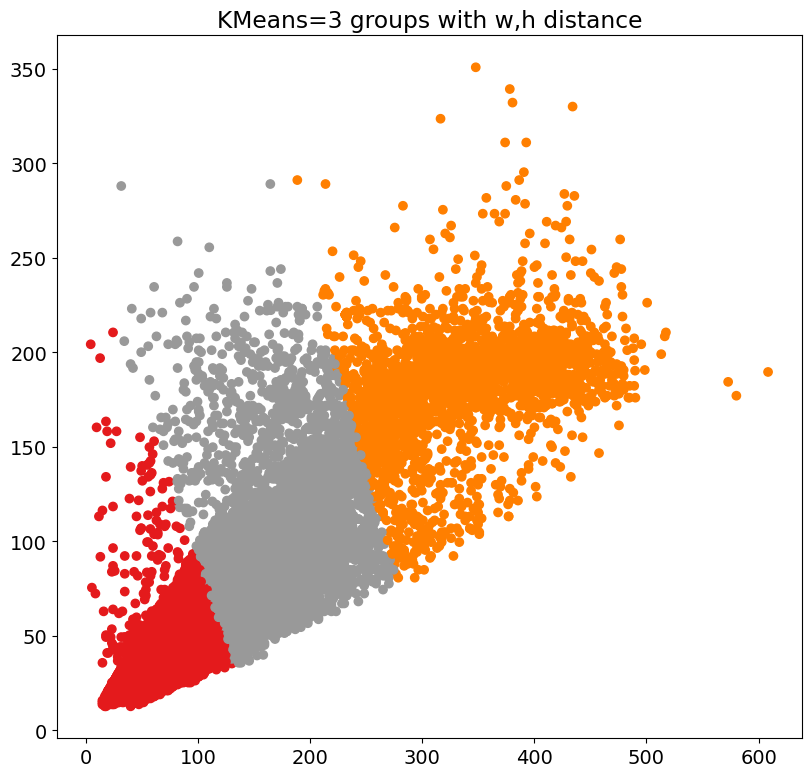

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

NUM_GROUP = 3

wh_data = []
for l in labels_all:
    wh_data.append([l.xmax - l.xmin, l.ymax - l.ymin])
wh_data = np.array(wh_data)

# print(wh_data.shape)

# 用 KMeans 在資料中找出 3 個分組
kmeans = KMeans(n_clusters=NUM_GROUP)
kmeans.fit(wh_data)

print(kmeans.cluster_centers_)

# 預測新的目標值 label
new_dy = kmeans.predict(wh_data)
plt.rcParams['font.size'] = 14
plt.figure(figsize=(16, 8))
print(f"new_dy = {new_dy}") # [2 0 1 ... 0 0 0]

# # 以不同顏色畫出原始的 10 群資料
# plt.subplot(121)
# plt.title('Original data (10 groups)')
# plt.scatter(dx.T[0], dx.T[1], c=dy, cmap=plt.cm.Set1)

# 根據重新分成的 3 組來畫出資料
plt.subplot(122)
plt.title(f'KMeans={NUM_GROUP} groups with w,h distance')
plt.scatter(wh_data.T[0], wh_data.T[1], c=new_dy, cmap=plt.cm.Set1)

# 顯示圖表
plt.tight_layout()
plt.show()


# Visualize Kmeans Result 

[740 575 623 ... 506 530 660]
[ 303 1038 1158 ...  338 1099  147]
[1047  652 1080 ...   65  186  753]


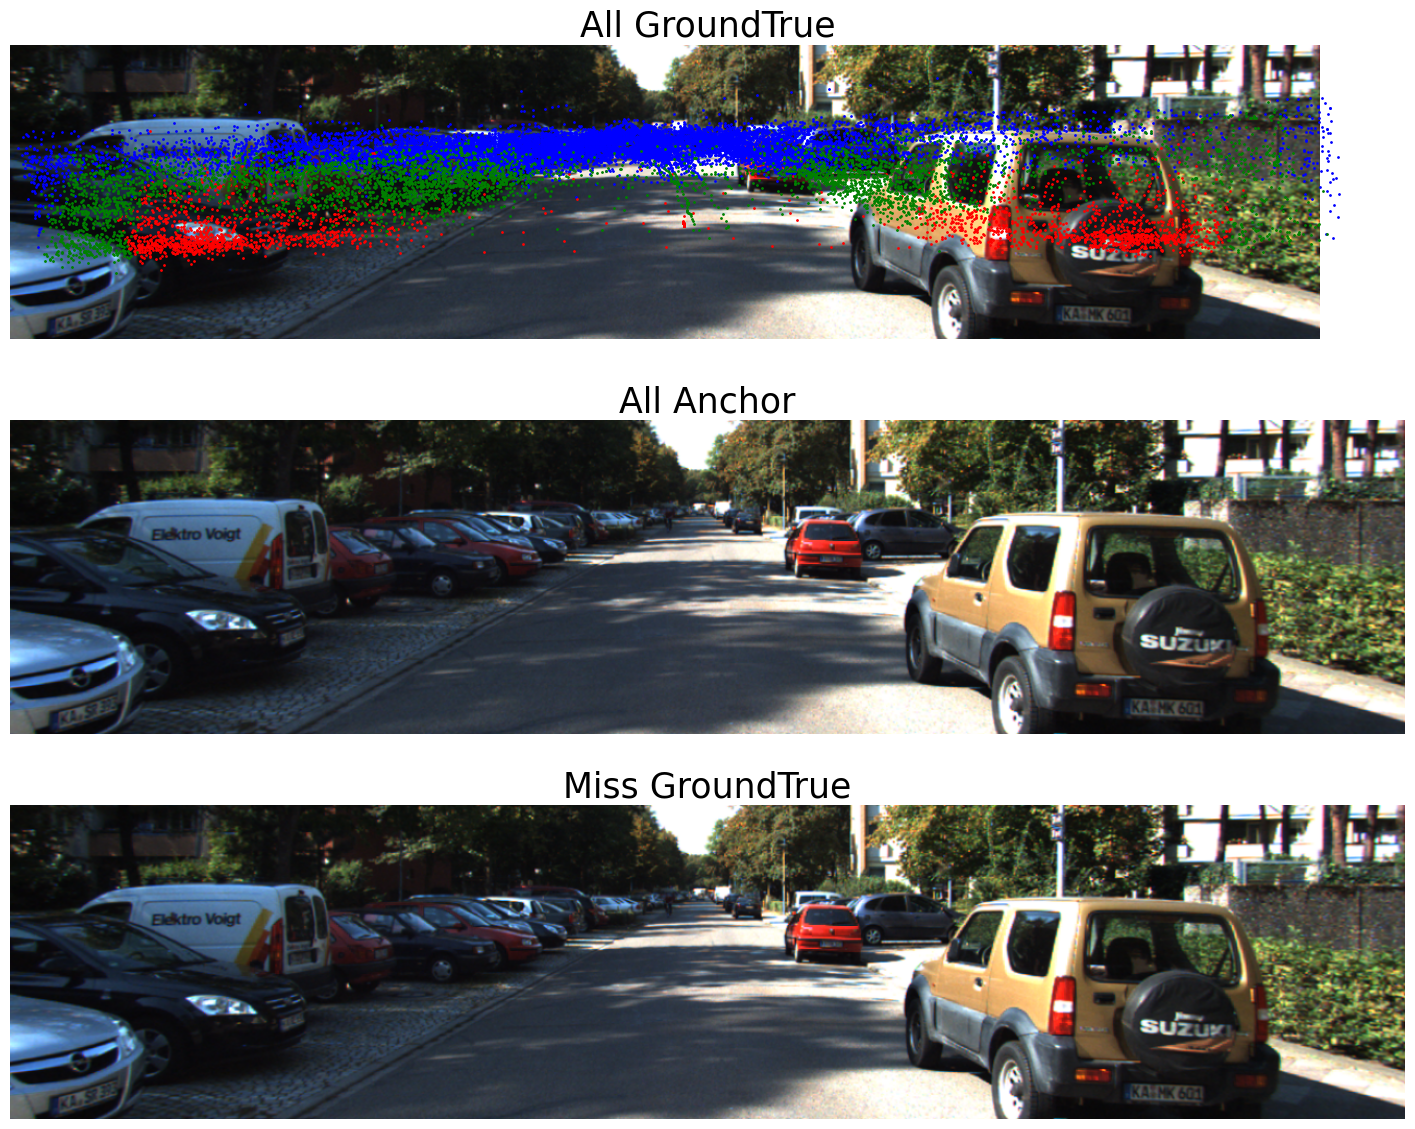

In [16]:
MARKER_SIZE = 2
axs = init_img_plt_without_bev([imgs_tf[0], imgs_tf[0], imgs_tf[0]], ["All GroundTrue", "All Anchor", "Miss GroundTrue"] )

# Draw Ground true
color = ['.b', '.r', '.g']
cluster_cxy = [ [], [] , [] ] #  [[[cx, cy], ....], [], []]
for i, l in enumerate(labels_all):
    cluster_id = new_dy[i]
    cluster_cxy[ cluster_id ].append([int((l.xmin+l.xmax)/2), int((l.ymin+l.ymax)/2) ])

for i in range(3):
    cluster_cxy[i] = np.array(cluster_cxy[i])

for i in range(3):
    print(cluster_cxy[i][:, 0])
    axs[0].plot(cluster_cxy[i][:, 0],
                cluster_cxy[i][:, 1], color[i], markersize=MARKER_SIZE)

# # Draw anchors
# axs[1].plot([int((a.xmin+a.xmax)/2) for a in anchors], 
#             [int((a.ymin+a.ymax)/2) for a in anchors], '.m', markersize=MARKER_SIZE)


# covered_gts = [] # [[x,y], ...]
# missed_gts  = [] # [[x,y], ...]
# for i, assign_list in enumerate(gt_assign_result):
#     if len(assign_list) > 0: # Covered gt
#         covered_gts.append( [int((labels_all[i].xmin + labels_all[i].xmax)/2), 
#                              int((labels_all[i].ymin + labels_all[i].ymax)/2)] )
#     else:
#         missed_gts.append( [int((labels_all[i].xmin + labels_all[i].xmax)/2), 
#                             int((labels_all[i].ymin + labels_all[i].ymax)/2)] )

# covered_gts = np.array(covered_gts)
# missed_gts  = np.array(missed_gts)
# # 
# # Draw Assignemnt result
# axs[2].plot(covered_gts[:,0], covered_gts[:,1], '.b',markersize=MARKER_SIZE)
# axs[2].plot(missed_gts [:,0], missed_gts [:,1], '.r',markersize=MARKER_SIZE)

